### Importing Libraries

In [48]:
import os
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.metrics import top_k_categorical_accuracy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, GlobalAveragePooling2D, Dense, concatenate, MaxPool2D , Input, AveragePooling2D, Dropout

### Constants

In [49]:
batch_size = 32
num_classes = 124
tf.random.set_seed(42)
img_height, img_width = 128, 128
data_dir = os.path.join(os.getcwd(), "../5-Gait-Energy-Images")

### Training Data Augmentation

In [50]:
train_datagen = ImageDataGenerator(
    shear_range=0.2,
    rescale=1.0 / 255,
    rotation_range=20,
    fill_mode="nearest",
    horizontal_flip=True,
    zoom_range=[0.8, 1.2],
    width_shift_range=0.2,
    validation_split=0.15,
    height_shift_range=0.2,
    channel_shift_range=10,
    brightness_range=[0.8, 1.2],
)

### Testing Data Augmentation

In [51]:
test_datagen = ImageDataGenerator(rescale=1.0 / 255, validation_split=0.15)

### Load and split data into training and testing sets

In [52]:
train_generator = train_datagen.flow_from_directory(
    data_dir,
    seed=42,
    shuffle=True,
    subset="training",
    batch_size=batch_size,
    color_mode="grayscale",
    class_mode="categorical",
    target_size=(img_height, img_width),
)

test_generator = test_datagen.flow_from_directory(
    data_dir,
    seed=42,
    shuffle=False,
    subset="validation",
    batch_size=batch_size,
    color_mode="grayscale",
    class_mode="categorical",
    target_size=(img_height, img_width),
)

Found 11587 images belonging to 124 classes.
Found 1974 images belonging to 124 classes.


### InceptionV3 Model

In [53]:
def conv_with_Batch_Normalisation(prev_layer , nbr_kernels , filter_Size , strides =(1,1) , padding = 'same'):
    x = Conv2D(filters=nbr_kernels, kernel_size = filter_Size, strides=strides , padding=padding)(prev_layer)
    x = BatchNormalization(axis=3)(x)
    x = Activation(activation='relu')(x)
    return x

def StemBlock(prev_layer):
    x = conv_with_Batch_Normalisation(prev_layer, nbr_kernels = 32, filter_Size=(3,3) , strides=(2,2))
    x = conv_with_Batch_Normalisation(x, nbr_kernels = 32, filter_Size=(3,3))
    x = conv_with_Batch_Normalisation(x, nbr_kernels = 64, filter_Size=(3,3))
    x = MaxPool2D(pool_size=(3,3) , strides=(2,2)) (x)
    x = conv_with_Batch_Normalisation(x, nbr_kernels = 80, filter_Size=(1,1))
    x = conv_with_Batch_Normalisation(x, nbr_kernels = 192, filter_Size=(3,3))
    x = MaxPool2D(pool_size=(3,3) , strides=(2,2)) (x)
    
    return x    
    
def InceptionBlock_A(prev_layer  , nbr_kernels):
    
    branch1 = conv_with_Batch_Normalisation(prev_layer, nbr_kernels = 64, filter_Size = (1,1))
    branch1 = conv_with_Batch_Normalisation(branch1, nbr_kernels=96, filter_Size=(3,3))
    branch1 = conv_with_Batch_Normalisation(branch1, nbr_kernels=96, filter_Size=(3,3))
    
    branch2 = conv_with_Batch_Normalisation(prev_layer, nbr_kernels=48, filter_Size=(1,1))
    branch2 = conv_with_Batch_Normalisation(branch2, nbr_kernels=64, filter_Size=(3,3)) # may be 3*3
    
    branch3 = AveragePooling2D(pool_size=(3,3) , strides=(1,1) , padding='same') (prev_layer)
    branch3 = conv_with_Batch_Normalisation(branch3, nbr_kernels = nbr_kernels, filter_Size = (1,1))
    
    branch4 = conv_with_Batch_Normalisation(prev_layer, nbr_kernels=64, filter_Size=(1,1))
    
    output = concatenate([branch1 , branch2 , branch3 , branch4], axis=3)
    
    return output

def InceptionBlock_B(prev_layer , nbr_kernels):
    
    branch1 = conv_with_Batch_Normalisation(prev_layer, nbr_kernels = nbr_kernels, filter_Size = (1,1))
    branch1 = conv_with_Batch_Normalisation(branch1, nbr_kernels = nbr_kernels, filter_Size = (7,1))
    branch1 = conv_with_Batch_Normalisation(branch1, nbr_kernels = nbr_kernels, filter_Size = (1,7))
    branch1 = conv_with_Batch_Normalisation(branch1, nbr_kernels = nbr_kernels, filter_Size = (7,1))    
    branch1 = conv_with_Batch_Normalisation(branch1, nbr_kernels = 192, filter_Size = (1,7))
    
    branch2 = conv_with_Batch_Normalisation(prev_layer, nbr_kernels = nbr_kernels, filter_Size = (1,1))
    branch2 = conv_with_Batch_Normalisation(branch2, nbr_kernels = nbr_kernels, filter_Size = (1,7))
    branch2 = conv_with_Batch_Normalisation(branch2, nbr_kernels = 192, filter_Size = (7,1))
    
    branch3 = AveragePooling2D(pool_size=(3,3) , strides=(1,1) , padding ='same') (prev_layer)
    branch3 = conv_with_Batch_Normalisation(branch3, nbr_kernels = 192, filter_Size = (1,1))
    
    branch4 = conv_with_Batch_Normalisation(prev_layer, nbr_kernels = 192, filter_Size = (1,1))
    
    output = concatenate([branch1 , branch2 , branch3 , branch4], axis = 3)
    
    return output    

def InceptionBlock_C(prev_layer):
    
    branch1 = conv_with_Batch_Normalisation(prev_layer, nbr_kernels = 448, filter_Size = (1,1))
    branch1 = conv_with_Batch_Normalisation(branch1, nbr_kernels = 384, filter_Size = (3,3))
    branch1_1 = conv_with_Batch_Normalisation(branch1, nbr_kernels = 384, filter_Size = (1,3))    
    branch1_2 = conv_with_Batch_Normalisation(branch1, nbr_kernels = 384, filter_Size = (3,1))
    branch1 = concatenate([branch1_1 , branch1_2], axis = 3)
    
    branch2 = conv_with_Batch_Normalisation(prev_layer, nbr_kernels = 384, filter_Size = (1,1))
    branch2_1 = conv_with_Batch_Normalisation(branch2, nbr_kernels = 384, filter_Size = (1,3))
    branch2_2 = conv_with_Batch_Normalisation(branch2, nbr_kernels = 384, filter_Size = (3,1))
    branch2 = concatenate([branch2_1 , branch2_2], axis = 3)
    
    branch3 = AveragePooling2D(pool_size=(3,3) , strides=(1,1) , padding='same')(prev_layer)
    branch3 = conv_with_Batch_Normalisation(branch3, nbr_kernels = 192, filter_Size = (1,1))
    
    branch4 = conv_with_Batch_Normalisation(prev_layer, nbr_kernels = 320, filter_Size = (1,1))
    
    output = concatenate([branch1 , branch2 , branch3 , branch4], axis = 3)
    
    return output

def ReductionBlock_A(prev_layer):
    
    branch1 = conv_with_Batch_Normalisation(prev_layer, nbr_kernels = 64, filter_Size = (1,1))
    branch1 = conv_with_Batch_Normalisation(branch1, nbr_kernels = 96, filter_Size = (3,3))
    branch1 = conv_with_Batch_Normalisation(branch1, nbr_kernels = 96, filter_Size = (3,3) , strides=(2,2) ) #, padding='valid'
    
    branch2 = conv_with_Batch_Normalisation(prev_layer, nbr_kernels = 384, filter_Size=(3,3) , strides=(2,2) )
    
    branch3 = MaxPool2D(pool_size=(3,3) , strides=(2,2) , padding='same')(prev_layer)
    
    output = concatenate([branch1 , branch2 , branch3], axis = 3)
    
    return output

def ReductionBlock_B(prev_layer):
    
    branch1 = conv_with_Batch_Normalisation(prev_layer, nbr_kernels = 192, filter_Size = (1,1))
    branch1 = conv_with_Batch_Normalisation(branch1, nbr_kernels = 192, filter_Size = (1,7))
    branch1 = conv_with_Batch_Normalisation(branch1, nbr_kernels = 192, filter_Size = (7,1))
    branch1 = conv_with_Batch_Normalisation(branch1, nbr_kernels = 192, filter_Size = (3,3) , strides=(2,2) , padding = 'valid')
    
    branch2 = conv_with_Batch_Normalisation(prev_layer, nbr_kernels = 192, filter_Size = (1,1) )
    branch2 = conv_with_Batch_Normalisation(branch2, nbr_kernels = 320, filter_Size = (3,3) , strides=(2,2) , padding='valid' )

    branch3 = MaxPool2D(pool_size=(3,3) , strides=(2,2) )(prev_layer)
    
    output = concatenate([branch1 , branch2 , branch3], axis = 3)
    
    return output

def InceptionV3():
    
    input_layer = Input(shape=(128 ,128 , 1))
    
    x = StemBlock(input_layer)
    
    x = InceptionBlock_A(prev_layer = x ,nbr_kernels = 32)
    x = InceptionBlock_A(prev_layer = x ,nbr_kernels = 64)
    x = InceptionBlock_A(prev_layer = x ,nbr_kernels = 64)
    
    x = ReductionBlock_A(prev_layer = x )
    
    x = InceptionBlock_B(prev_layer = x  , nbr_kernels = 128)
    x = InceptionBlock_B(prev_layer = x , nbr_kernels = 160)
    x = InceptionBlock_B(prev_layer = x , nbr_kernels = 160)
    x = InceptionBlock_B(prev_layer = x , nbr_kernels = 192)
    
    x = ReductionBlock_B(prev_layer = x)
    
    x = InceptionBlock_C(prev_layer = x)
    x = InceptionBlock_C(prev_layer = x)
    
    x = GlobalAveragePooling2D()(x)
    x = Dense(units=2048, activation='relu') (x)
    x = Dropout(rate = 0.2) (x)
    x = Dense(units=124, activation='softmax') (x)
    
    model = Model(inputs = input_layer , outputs = x , name = 'Inception-V3')
    return model

### Create the model

In [54]:
model = InceptionV3()

### Define Top k Accuracy Function

In [55]:
def top_5_accuracy(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=5)

### Compile the model

In [56]:
model.compile(optimizer='adam', loss='categorical_crossentropy',
              metrics=['acc', top_5_accuracy])

### Define the Callbacks

In [57]:
checkpoint = ModelCheckpoint(
    "best_model.h5", monitor='val_acc', save_best_only=True, mode='max')
early_stopping = EarlyStopping(
    monitor='val_acc', patience=30, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(
    monitor='val_acc', factor=0.1, patience=5, min_lr=1e-7)

### Train the model

In [58]:
history = model.fit(
    train_generator,
    validation_data=test_generator,
    epochs=500,
    callbacks=[checkpoint, early_stopping, reduce_lr],
    use_multiprocessing=True)

Epoch 1/500


363/363 [==============================] - 220s 518ms/step - loss: 4.7812 - acc: 0.0124 - top_5_accuracy: 0.0601 - val_loss: 10.0868 - val_acc: 0.0167 - val_top_5_accuracy: 0.0912 - lr: 0.0010
Epoch 2/500
363/363 [==============================] - 183s 500ms/step - loss: 4.4786 - acc: 0.0232 - top_5_accuracy: 0.1088 - val_loss: 7.7497 - val_acc: 0.0223 - val_top_5_accuracy: 0.0790 - lr: 0.0010
Epoch 3/500
363/363 [==============================] - 177s 483ms/step - loss: 4.1917 - acc: 0.0469 - top_5_accuracy: 0.1856 - val_loss: 10.7921 - val_acc: 0.0086 - val_top_5_accuracy: 0.0669 - lr: 0.0010
Epoch 4/500
363/363 [==============================] - 178s 486ms/step - loss: 3.9360 - acc: 0.0668 - top_5_accuracy: 0.2518 - val_loss: 5.0005 - val_acc: 0.0415 - val_top_5_accuracy: 0.1697 - lr: 0.0010
Epoch 5/500
363/363 [==============================] - 178s 487ms/step - loss: 3.7612 - acc: 0.0866 - top_5_accuracy: 0.2987 - val_loss: 3.6683 - val_acc: 0.0775 - val_top_5_accuracy: 0.3024 - l

### Evaluate model on training set

In [59]:
train_loss, train_accuracy, top5train = model.evaluate(train_generator)
print(f"Training Loss: {round(train_loss, 2)}")
print(f"Training Accuracy: {round(train_accuracy, 2)}")
print(f"Training Top 5 Accuracy: {round(top5train, 2)}")

363/363 [==============================] - 56s 155ms/step - loss: 0.4587 - acc: 0.8642 - top_5_accuracy: 0.9820
Training Loss: 0.46
Training Accuracy: 0.86
Training Top 5 Accuracy: 0.98


### Evaluate model on testing set

In [60]:
test_loss, test_accuracy, top5test = model.evaluate(test_generator)
print(f"Testing Loss: {round(test_loss, 2)}")
print(f"Testing Accuracy: {round(test_accuracy, 2)}")
print(f"Testing Top 5 Accuracy: {round(top5test, 2)}")

62/62 [==============================] - 9s 142ms/step - loss: 1.0916 - acc: 0.7158 - top_5_accuracy: 0.9189
Testing Loss: 1.09
Testing Accuracy: 0.72
Testing Top 5 Accuracy: 0.92


### Save the model

In [61]:
model.save('../10-Trained-Models/InceptionV3.h5')

### Model Summary

In [62]:
model.summary()

Model: "Inception-V3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 128, 128, 1)]        0         []                            
                                                                                                  
 conv2d_282 (Conv2D)         (None, 64, 64, 32)           320       ['input_4[0][0]']             
                                                                                                  
 batch_normalization_282 (B  (None, 64, 64, 32)           128       ['conv2d_282[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 activation_282 (Activation  (None, 64, 64, 32)           0         ['batch_normalizati

### Plot Training & Validation Accuracy

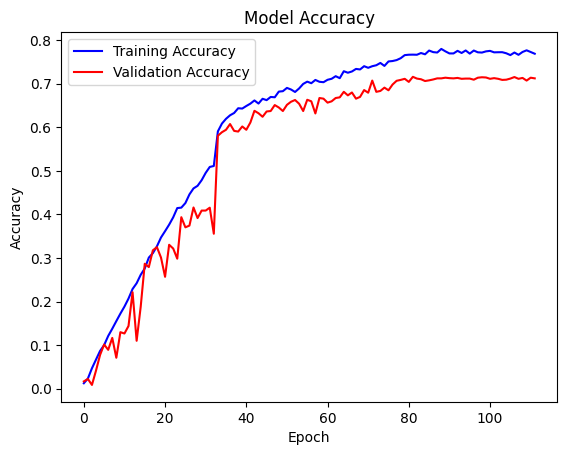

In [63]:
plt.plot(history.history['acc'], color='blue', label='Training Accuracy')
plt.plot(history.history['val_acc'],
         color='red', label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### Plot Training and Validation Loss

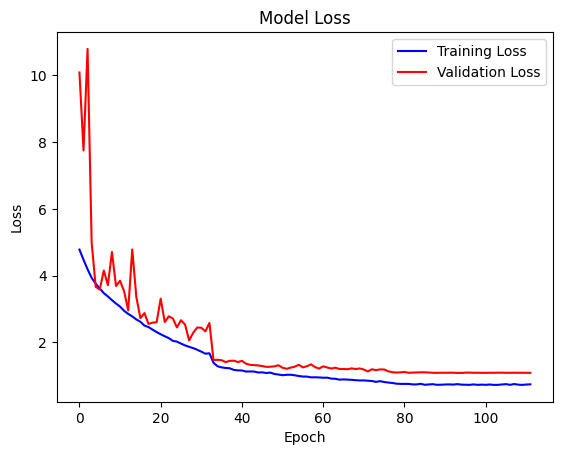

In [64]:
plt.plot(history.history['loss'], color='blue', label='Training Loss')
plt.plot(history.history['val_loss'],
         color='red', label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Plot Training and Testing Top 5 Accuracy

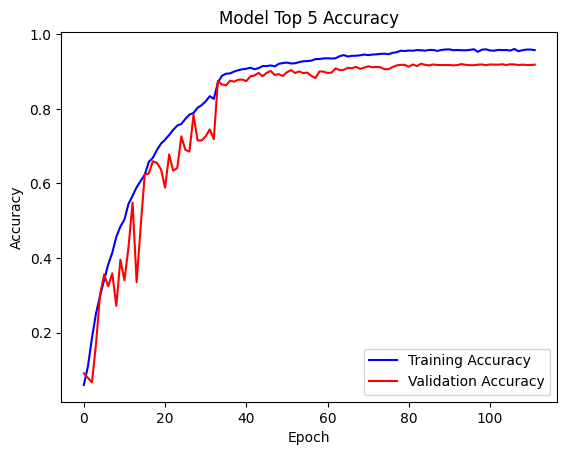

In [65]:
plt.plot(history.history['top_5_accuracy'],
         color='blue', label='Training Accuracy')
plt.plot(history.history['val_top_5_accuracy'],
         color='red', label='Validation Accuracy')
plt.title('Model Top 5 Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()